In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-shoppers/online_shoppers_intention.csv


In [2]:
data = pd.read_csv('/kaggle/input/online-shoppers/online_shoppers_intention.csv')

In [3]:
data.head()
print("Shape:", data.shape)
print("\nMissing values:\n", data.isnull().sum())
print("\nData types:\n", data.dtypes)


Shape: (12330, 18)

Missing values:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Data types:
 Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             

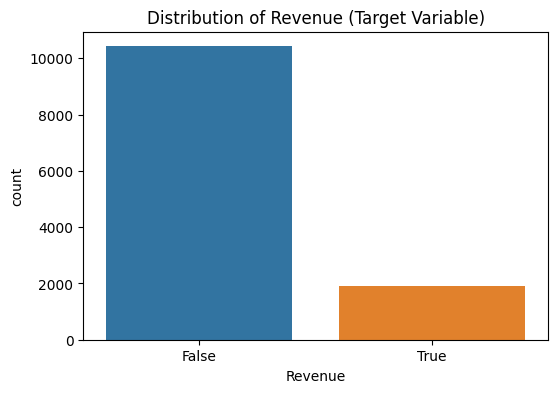


Class balance:
 Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Revenue', data=data)
plt.title('Distribution of Revenue (Target Variable)')
plt.show()

# Check class imbalance
print("\nClass balance:\n", data['Revenue'].value_counts(normalize=True))

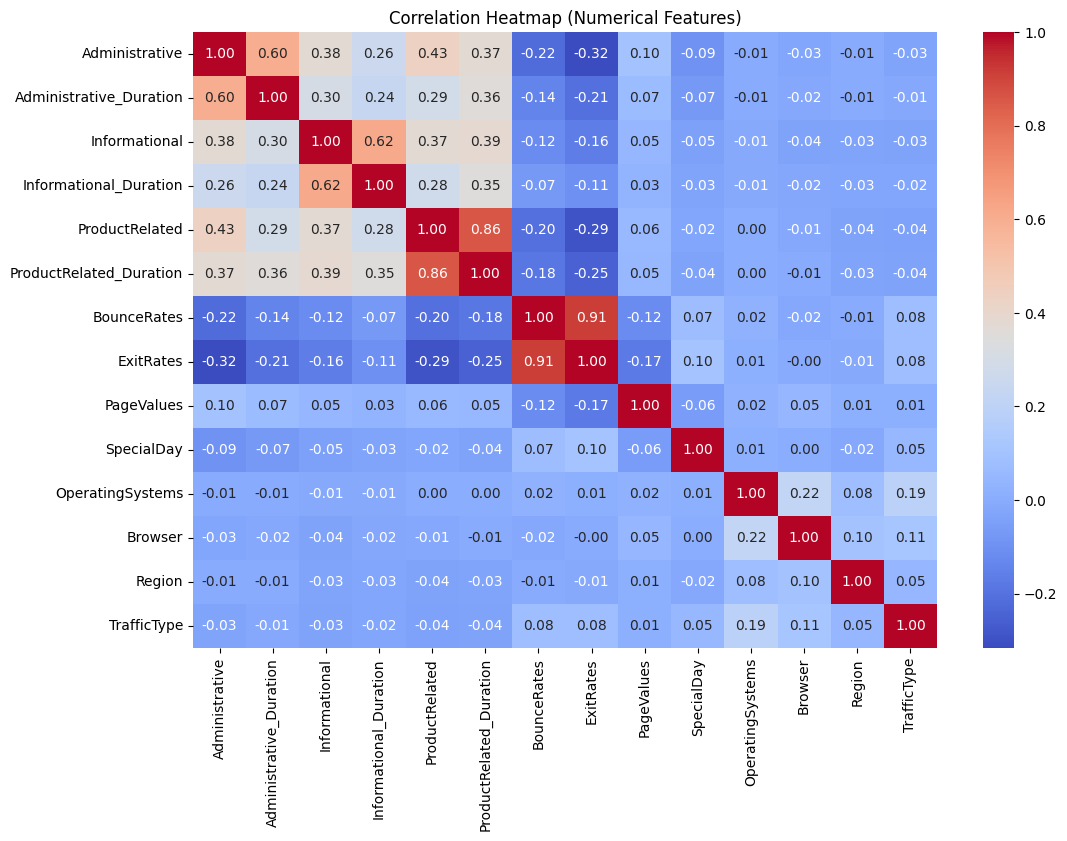

In [5]:
# Select numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

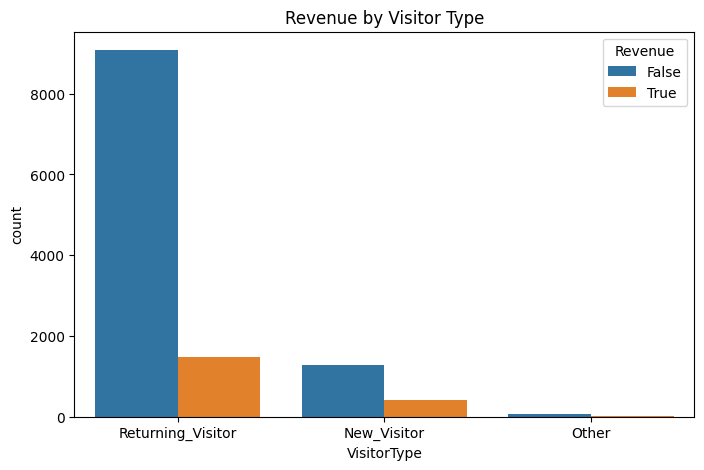

In [6]:
# Contoh: VisitorType vs Revenue
plt.figure(figsize=(8, 5))
sns.countplot(x='VisitorType', hue='Revenue', data=data)
plt.title('Revenue by Visitor Type')
plt.show()

In [7]:
# Define features and target
X = data.drop('Revenue', axis=1)
y = data['Revenue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipeline
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])




Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.74      0.52      0.61       382

    accuracy                           0.90      2466
   macro avg       0.83      0.74      0.77      2466
weighted avg       0.89      0.90      0.89      2466


ROC-AUC Score: 0.9166926269457648


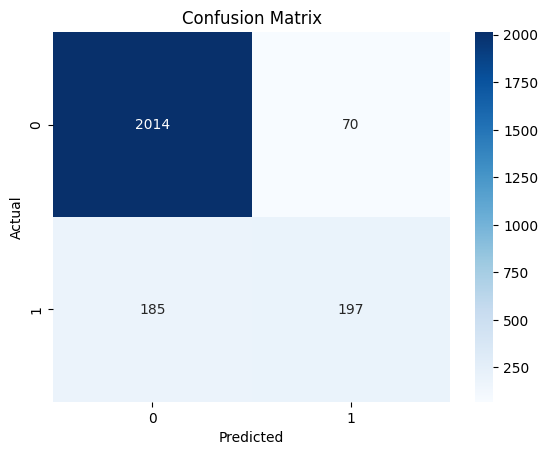

In [8]:
# Pipeline dengan RandomForest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluasi
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

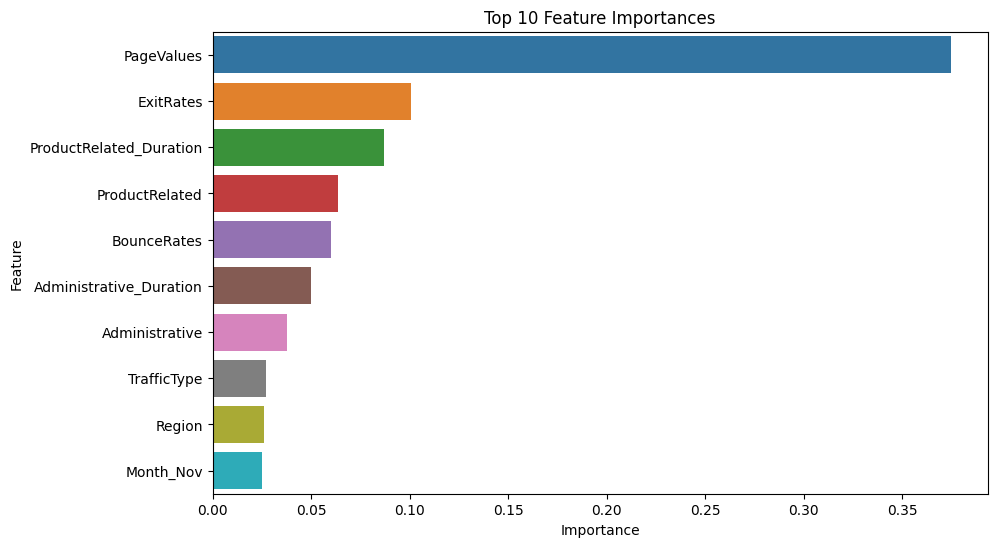

In [9]:
# Ekstrak feature importance
feature_importances = model.named_steps['classifier'].feature_importances_

# Dapatkan nama feature setelah preprocessing
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_features_encoded = cat_encoder.get_feature_names_out(cat_features)
all_features = num_features + list(cat_features_encoded)

# Gabungkan dengan importance
importance_data = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
importance_data = importance_data.sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_data.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Tuning hyperparameter
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC-AUC: 0.9300393646706789
